# Part of Speech tagging

Authors:
* Konstantin Taranov (exercise code and descriptions)
* Ondrej Skopek (rewrite to a Jupyter Notebook)

Language Modelling
* Recognizing words
* LM Size: |V|

Part of Speech Tagging:
* Categories of words with different meanings, but using the same word
* Tagging: Assigning a word to category
* Categories: Noun, Verb, Adjective, Preposition, Conjunction
* PoS Size: |tags| << |V|

Named entity recognition
* Recognizing entities, usually nouns
* Span labeling
    
Hidden Markov Models (HMM)
* Bayesian Network, graphical model (is represented by a graph)
    * Graph: Discrete states
* Sunny weather, rainy weather


### Problem 1
#### A
Using dynamic programming, the states are saved as well the s the probability of being in a particular state. This solves the probme of computing the probability of $w_n$ using a sequence for each state, and instead just use the sum of probabilities of going to the state $\alpha_t(j) = \sum_{i=1}^N \alpha_{t-1}(i) a_{ij} b_{j}o(t)$


#### B
$P(O) = \sum_Q P(O|Q) P(Q)$ where $|Q| = N$ and $|O|=T$, in total there are $N^T$ possible sequences/paths through the graph.

#### C
O(N^2 T) Running time. 
See book for expressions, cba writing them here.

### Problem 2
#### A
Rows have to sum to 1.

#### B
Calcualte probability of the sequence  $O = \{dry, soaked, dry\}$.

In [7]:
a = np.array([
    [0.6, 0.4], # (sunny -> sunny) and (sunny -> rainy)
    [0.3, 0.7]  # (rainy -> sunny) and (rainy -> rainy)
]) 

b = np.array([
    [0.9, 0.1], # (dry | sunny) and (soaked | sunny)
    [0.2, 0.8] # (rainy | dry) and (soaked | rainy)
])

pi = np.array([0.3, 0.7]) # sunny, rainy

In [13]:
# start -> dry
alpha_1s = pi[0] * b[0,0]
alpha_1r = pi[1] * b[1,0]
alpha_1s, alpha_1r

(0.27, 0.13999999999999999)

In [14]:
# start -> dry -> soaked
alpha_2s = (alpha_1s * a[0,0] + alpha_1r * a[1,0]) * b[0,1]
alpha_2r = (alpha_1s * a[0,1] + alpha_1r * a[1,1]) * b[1,1]
alpha_2s, alpha_2r

(0.0204, 0.16480000000000003)

In [15]:
# start -> dry -> soaked -> dry
alpha_3s = (alpha_2s * a[0,0] + alpha_2r * a[1,0]) * b[0,0]
alpha_3r = (alpha_2s * a[0,1] + alpha_2r * a[1,1]) * b[1,0]
alpha_3s, alpha_3r

(0.055512000000000006, 0.024704000000000004)

In [16]:
P = alpha_3s + alpha_3r
print('P([dry, soaked, dry] | A, B, PI) =', P)

P([dry, soaked, dry] | A, B, PI) = 0.08021600000000001


#### C
Viterbi algorithm computes the transition sequence between hidden states with max likelihood, given an observation sequence.

#### D
Find most probale sequence of hidden states $O = \{dry, soaked, dry\}$.

In [17]:
labels = np.array(['Sunny', 'Rainy'])
states = np.array([
    [alpha_1s, alpha_1r],
    [alpha_2s, alpha_2r],
    [alpha_3s, alpha_3r],
])

In [18]:
for s in states:
    print(labels[s.argmax()])

Sunny
Rainy
Sunny


In [19]:
def forward(a, b, pi, seq):
    '''
    a   : Matrix float [m x m] <state -> state matrix>
    b   : Matrix float [m x n] <(obs|state) matrix>
    pi  : Array  float [m]     <starting probabilities>
    seq : Array  int   [N]     <enumeration of observations>
    '''
    m, n = b.shape
    N = len(seq)
    F = np.zeros((N, n))
    
    # Intialization step
    F[0] = pi * b[:, 0]
    
    # Recursion step
    for t in range(1, N):
        o = seq[t]
        for i in range(m):
            for j in range(m):
                F[t, i] += F[t-1, j] * a[j, i] * b[i, o]
    
    # Termination step
    P = F[-1].sum()

    return P

In [20]:
# O = dry -> soaked -> dry
s = [0, 1, 0]
forward(a, b, pi, s)

0.08021600000000001

In [21]:
def viterbi(a, b, pi, seq):
    '''
    a   : Matrix float [m x m] <state -> state matrix>
    b   : Matrix float [m x n] <(obs|state) matrix>
    pi  : Array  float [m]     <starting probabilities>
    seq : Array  int   [N]     <enumeration of observations>
    |O| (seq) = T
    |Q| (hidden states, rows in B) = m
    '''
    N = b.shape[0]
    T = len(seq)
    viter = np.zeros((N, T)) # Viterbi matrix
    backpoint = np.zeros((N, T)) # Backpointer matrix
   
    
    # 1: Intialization step
    viter[:, 0] = pi * b[:, 0] # Set first column to start probs
    backpoint[:, 0] = 0            # Set first column to zero

    # 2: Recursion step
    viterbi_current = np.zeros(N)
    for t in range(1, T):
        ot = seq[t]
        for s in range(N):
            for sp in range(N):
                viterbi_current[sp] = viter[s, t-1] * a[sp, s] * b[s, ot]
            
            viter[s, t] = viterbi_current.max()
            backpoint[s, t] = viterbi_current.argmax()
    
    # 3: Termination step
    best_path_prob = viter[:, T-1].max()
    best_path_pointer = backpoint[:, T-1].argmax()
    
    # Start backtracking
    best_path = np.zeros(T)
    for t in reversed(range(T-1)):
        best_path[t] = backpoint[:, t].argmax()
    
    # Finished
    return best_path.astype(int), best_path_prob

In [22]:
path, prob = viterbi(a, b, pi, s)

In [23]:
print('Best path', labels[path])
print('Best prob', prob)

Best path ['Sunny' 'Rainy' 'Sunny']
Best prob 0.010976


## Imports and visualization functions

In [24]:
import nltk
import numpy as np
import ssl
from pylab import *
font = {'weight' : 'normal', 'size'   : 16}
matplotlib.rc('font', **font)

In [25]:
# Solves the problem with SSL certificates while downloading nltk packets
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('tagsets')

from IPython.display import HTML, display, Markdown
import tabulate

def md(*md):
    """Displays rendered Markdown."""
    display(Markdown(" ".join(map(str, md))))
b
def show_tags(tags):
    """Displays an HTML table for a tagged sentence."""
    tags = list(map(list, zip(*tags)))
    display(HTML(tabulate.tabulate(tags, tablefmt='html')))
    
def show_viterbi(viterbi, tags, sentence, t):
    """Displays an HTML table for a Viterbi matrix."""
    md("#### Viterbi probabilities at time $t = {}$".format(t))
    viterbi = viterbi.tolist()
    for tag_idx, row in enumerate(viterbi):
        new_row = [tags[tag_idx]]
        for sent_idx, element in enumerate(row):
            new_row.append("0" if element == 0 else "{:.2e}".format(element))
        viterbi[tag_idx] = new_row
    viterbi.insert(0, [""] + sentence)
    
    display(HTML(tabulate.tabulate(viterbi, tablefmt='html')))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thomasnilsson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/thomasnilsson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/thomasnilsson/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/thomasnilsson/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


## PoS tagging

PoS tagging is the process of tagging a word in a text where the tag is a particular part of speech mark.

The 12 universal tags are:

* `VERB` - verbs (all tenses and modes)
* `NOUN` - nouns (common and proper)
* `PRON` - pronouns
* `ADJ` - adjectives
* `ADV` - adverbs
* `ADP` - adpositions (prepositions and postpositions)
* `CONJ` - conjunctions
* `DET` - determiners
* `NUM` - cardinal numbers
* `PRT` - particles or other function words
* `X` - other: foreign words, typos, abbreviations
* `.` - punctuation

### Examples of tagging:

In [26]:
text = nltk.word_tokenize("ETH is the best university in the world.")
tags = nltk.pos_tag(text,tagset='universal')
show_tags(tags)

ETH,is,the,best,university,in,the,world,.
NOUN,VERB,DET,ADJ,NOUN,ADP,DET,NOUN,.


In [27]:
text = nltk.word_tokenize("Dogs are animals.")
tags = nltk.pos_tag(text,tagset='universal')
show_tags(tags)

Dogs,are,animals,.
NOUN,VERB,NOUN,.


## Implementing your own PoS tagger

In this exercise, you should implement your own PoS tagger using a Hidden Markov Model.

For learning your model the following Tagged Corpora can be used:

In [28]:
# nltk.download('treebank')
#from nltk.corpus import treebank as corpus

nltk.download('brown')
from nltk.corpus import brown as corpus

[nltk_data] Downloading package brown to
[nltk_data]     /Users/thomasnilsson/nltk_data...
[nltk_data]   Package brown is already up-to-date!


First, we add an artificial `START` and `END` tag at the beginning and end of each sentence.

In [29]:
tagged_words = []
all_tags = []

for sent in corpus.tagged_sents(tagset='universal'):
    tagged_words.append(("START", "START"))
    all_tags.append("START")
    for word, tag in sent:
        all_tags.append(tag)
        tagged_words.append((tag, word))
    tagged_words.append(("END", "END"))
    all_tags.append("END")

### Estimating probabilities
For the Viterbi algorithm we need to compute:

1. The maximum likelihood estimate of a transition probability

$$P(t_{i} | t_{i-1}) = \frac{C(t_{i-1}, t_{i})}{C(t_{i-1})}$$

2. Emission probabilities

$$P(w_{i} | t_{i}) =  \frac{C(t_{i}, w_{i})}{C(t_{i})}$$

#### Transitions

Compute $C(t_{i-1}, t_{i})$

In [31]:
cfd_tags= nltk.ConditionalFreqDist(nltk.bigrams(all_tags))

<Figure size 1440x720 with 0 Axes>

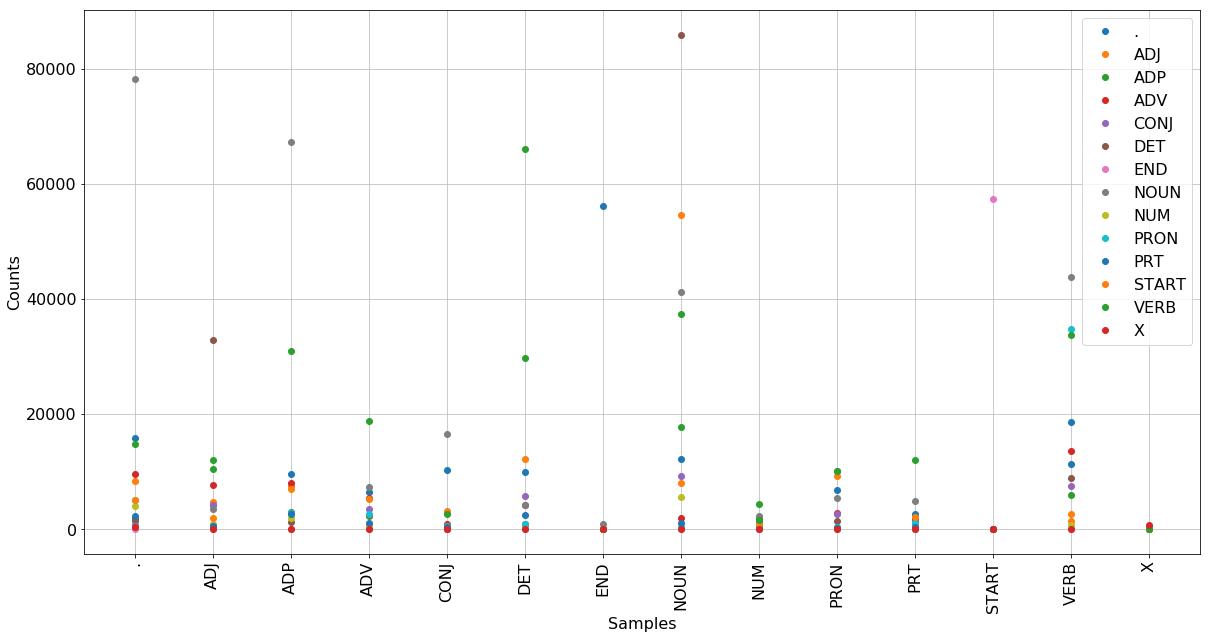

In [32]:
figure(figsize=[20,10])
cfd_tags.plot('.', markersize=12)

Transition probabilities $P(t_{i} | t_{i-1})$

In [33]:
cpd_tags = nltk.ConditionalProbDist(cfd_tags, nltk.MLEProbDist)

In [34]:
cpd_tags.keys()

dict_keys(['START', 'DET', 'NOUN', 'ADJ', 'VERB', 'ADP', '.', 'END', 'ADV', 'CONJ', 'PRT', 'PRON', 'NUM', 'X'])

##### Examples

In [35]:
# C('DET', 'NOUN'):
print("Frequency of C('DET', 'NOUN') is",
      cfd_tags['DET']['NOUN'] )

# P('NOUN' | 'DET')
print("Probability of P('NOUN' | 'DET') is",
      cpd_tags['DET'].prob('NOUN') )

Frequency of C('DET', 'NOUN') is 85838
Probability of P('NOUN' | 'DET') is 0.6264678621213117


#### Emmision

Compute $C(t_{i}, w_{i})$

In [36]:
cfd_tagwords = nltk.ConditionalFreqDist(tagged_words)

Emission probabilities $P(w_{i} | t_{i})$

In [37]:
cpd_tagwords = nltk.ConditionalProbDist(cfd_tagwords, nltk.MLEProbDist)

##### Examples

In [38]:
# C('DET', 'NOUN'):
print("Frequency of C('DET', 'the') is",
      cfd_tagwords['DET']['the'])

# P('the' | 'DET')
print("Probability of P('the' | 'DET') is",
      cpd_tagwords['DET'].prob('the') )

# P(!'the' | 'DET')
print("Probability of P(!'the' | 'DET') is",
      1 - cpd_tagwords['DET'].prob('the') )

Frequency of C('DET', 'the') is 62710
Probability of P('the' | 'DET') is 0.45767375327509324
Probability of P(!'the' | 'DET') is 0.5423262467249068


### Task 1 (Joint probability)

Estimate the joint probability $P(t^{n}, w^{n})$ of the tag sequence `[NOUN VERB VERB .]` for the word sequence `[birds can fly .]` 
using the transition and emission probabilities estimated above.

Bonus: Implement the task in both raw probabilities and log probabilities.

#### Task 1: Code

In [39]:
# Raw probability
raw =   cpd_tags['START'].prob('NOUN') * cpd_tagwords['NOUN'].prob('birds') * \
        cpd_tags['NOUN'].prob('VERB') * cpd_tagwords['VERB'].prob('can') * \
        cpd_tags['VERB'].prob('VERB') * cpd_tagwords['VERB'].prob('fly') * \
        cpd_tags['VERB'].prob('.') * cpd_tagwords['.'].prob('.') * \
        cpd_tags['.'].prob('END')

In [40]:
def joint_raw(tags, words):
    # Check if same number of words and tags
    N = len(tags)
    if N != len(words): raise Exception('Tag seq. and word seq. are not of the same length!')
    
    # Special case for first word
    P = cpd_tags['START'].prob(tags[0]) * cpd_tagwords[tags[0]].prob(words[0])
    
    # Everything in the middle
    for i in range(1, N):
        P *=  cpd_tags[tags[i-1]].prob(tags[i]) * \
        cpd_tagwords[tags[i]].prob(words[i])
        
    # Special case for last word
    P *= cpd_tags[tags[-1]].prob('END')
    
    return P

In [41]:
tags = nltk.word_tokenize('NOUN VERB VERB.')
seq = nltk.word_tokenize('birds can fly.')
joint_raw(tags, seq)

6.593297174568127e-15

In [42]:
raw

6.5932971745681245e-15

### Task 2 (Viterbi algorithm)

Implement the Viterbi algorithm for PoS tagging.

Bonus: Implement the task in both raw probabilities and log probabilities.

#### Code

In [247]:
def viterbi_pos(a, b, seq):
    '''
    a       : cpd_tags                <(state[j] | state[i]) matrix>
    b       : cpd_tagwords            <(obs[t] | state[j]) matrix>
    seq     : sentence to tag         <observations>
    T = |O| : Number of distinct tags
    N = |Q| : Length of sequence
    ''' 
    START_TAG, END_TAG = 'START', 'END'
    tags = np.array(list(b.keys()))
    N = len(tags)
    T = len(seq)    
    
    # Viterbi matrix
    viterbi = np.zeros((N, T+1), dtype=float) 
    
    # Backpointer matrix, first column already set to zero
    backpointer = np.zeros((N, T+1), dtype=int) 
    
    # 1: INIT STEP (t = 0)
    for s, tag in enumerate(tags):
        viterbi[s, 0] = a[START_TAG].prob(tag) * b[tag].prob(seq[0])
        
    # 2: RECURSION STEP (t = 1 ... T-1)
    for t in range(1, T):
        viterbi_temp = np.zeros(N, dtype=float)
        for s, tag in enumerate(tags):
            for sp, tagp in enumerate(tags):
                viterbi_temp[sp] = viterbi[sp, t-1] * a[tagp].prob(tag) *b[tag] .prob(seq[t])
            viterbi[s, t] = viterbi_temp.max()
            backpointer[s, t] = viterbi_temp.argmax()
        
    # Edge case for last index (t = T)
    for s, tag in enumerate(tags):  
        viterbi_temp[s] = viterbi[s, T-1] * a[tag].prob(END_TAG)
    
    s_end = np.where(tags == END_TAG)[0][0]
    viterbi[s_end, T] = viterbi_temp.max()
    backpointer[s_end, T] = viterbi_temp.argmax()
    
    # 3: TERMINATION STEP
    best_path_prob = viterbi[:, T].max()
    # Take the highest backpointer values, omit the first token (START token)
    best_path = backpointer.max(axis=0)[1:] 
    
    return best_path, best_path_prob

### Task 3

Using your HMM, try to tag the sentences below. Then, answer the following questions:
* Why does it fail to predict tags for the sentence about ETH?
  * Could it just have mislabeled the sentence because it disagreed with the statement? ;-)

In [ ]:
tag_labels = np.array(list(cpd_tagwords.keys()))

In [259]:
sentence = nltk.word_tokenize("The dog is mine.")
path, prob = viterbi_pos(cpd_tags, cpd_tagwords, sentence)
show_tags(zip(sentence, tag_labels[path]))
print('Prob', prob)

The,dog,is,mine,.
DET,NOUN,VERB,PRON,.


Prob 8.294025685357724e-15


In [260]:
sentence = nltk.word_tokenize("I am a carrot and my dog is a cat.")
path, prob = viterbi_pos(cpd_tags, cpd_tagwords, sentence)
show_tags(zip(sentence, tags[path]))
print('Prob', prob)

I,am,a,carrot,and,my,dog,is,a,cat,.
PRON,VERB,DET,NOUN,CONJ,DET,NOUN,VERB,DET,NOUN,.


Prob 3.1210239555751608e-30
